### ***Introduction***

Skin cancer is a widespread and potentially life-threatening condition affecting millions worldwide. Timely detection significantly increases survival rates, and in this digital age, Convolutional Neural Networks (CNNs) have emerged as powerful allies in automating this process.

The serves as a detailed roadmap for ML Experts, ML Beginners and Product Managers,  constructing a CNN model aimed at skin cancer detection, leveraging the HAM10000 dataset—a meticulously curated collection of skin lesion images. Beyond the technical nuances, this guide explores the transformative impact of integrating advanced technology, such as CNNs, into healthcare, particularly in the realm of dermatology.

By unraveling the intricacies of CNN implementation, this guide aims to empower both professionals and enthusiasts alike. Its objective is to illuminate the possibilities and implications of employing artificial intelligence to revolutionize skin cancer detection. Ultimately, this fusion of technology and healthcare seeks to expedite diagnosis, elevate patient care standards, and significantly impact global health outcomes.

## ***About Dataset***

The HAM10000 dataset is a significant compilation utilized for skin cancer classification, encompassing a diverse array of dermatoscopic images portraying various skin lesions categorized into distinct types of skin cancer.

Each image within this dataset is accompanied by crucial attributes such as age, gender, and localization, furnishing valuable information indispensable for analysis and classification tasks within the domain of dermatology.

## ***Key Dataset Components:***

HAM10000_images_part_1 and HAM10000_images_part_2: These folders house 5000 and 5015 dermatoscopic images, respectively.
HAM10000_metadata.csv: This file contains columns like 'lesion_id', 'image_id', 'dx' (Diagnosis), 'dx_type' (Diagnosis technique), 'age', 'sex', and 'localization' (Body part).


## ***Purpose and Composition: ***

The dataset's objective is to facilitate neural network training for automated diagnosis of pigmented skin lesions. It consists of 10015 dermatoscopic images collected from different populations and modalities, showcasing a representative collection of key diagnostic categories: Actinic keratoses, Basal cell carcinoma, Melanoma, Nevi, and others.
Ground Truth and Validation: Over 50% of the lesions are confirmed through histopathology. The remainder is verified through follow-up examination, expert consensus, or in-vivo confocal microscopy.
Additional Data: For evaluation, the dataset includes test-set images and ground-truth data available as ISIC2018_Task3_Test_Images.zip and ISIC2018_Task3_Test_GroundTruth.csv, respectively.
Dataset Significance and Impact:

## ***Challenges and Research: ***


The HAM10000 dataset served as a pivotal component for the ISIC 2018 challenge (Task 3), where test-set evaluations outperformed expert readers on an international scale.
Additionally, it facilitated studies comparing human-computer collaboration scenarios, revealing the potential for improved diagnostic accuracy through machine learning augmentation.


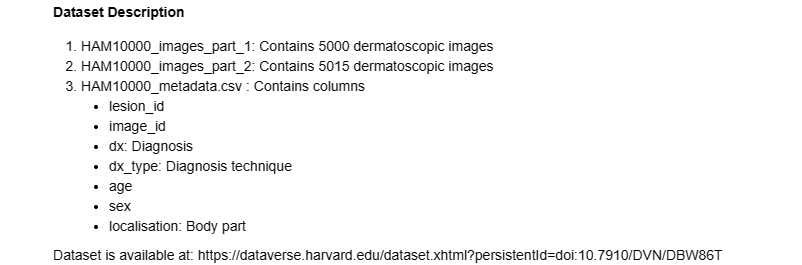

Outline


Importing Libraries


Loading and Understanding the Dataset


Creating a Dictionary for Image Path and Lesion Type


Exploratory Data Analysis (EDA)


Preprocessing


Data Augmentation


Model Creation, Training, and Testing


Evaluation and Testing of Models


Plotting Model Training Curve and Testing

## ***Importing Libraries***


This section imports essential libraries like NumPy, Pandas, TensorFlow, and PIL (Python Imaging Library). These libraries are crucial for data manipulation, image processing, machine learning model building, and evaluation.

In [ ]:
# Importing Libraries
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

## ***Loading and Understanding the Dataset***


It sets the directory path and loads the metadata CSV file containing information about the skin lesion dataset, utilizing Pandas' read_csv function.

In [ ]:
# Setting data directory
data_directory = os.path.join("/kaggle/input/", "skin-cancer-mnist-ham10000/")
os.listdir(data_directory)
# Loading HAM10000_meatdata.csv
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))


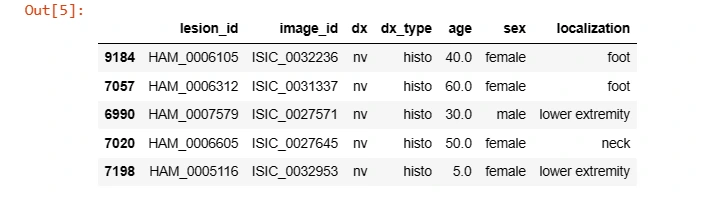

## ***Creating a Dictionary for Image Path and Lesion Type***

This code creates dictionaries to map image IDs to their file paths and lesion types for further data mapping and augmentation.

In [ ]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

%%time
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
data.sample(5)


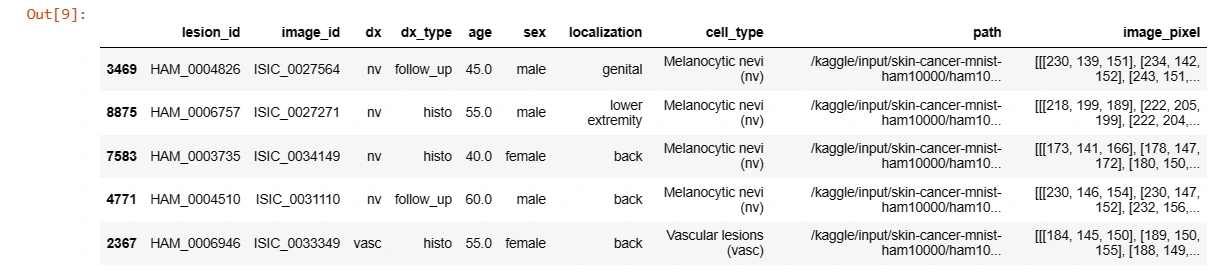

## ***Exploratory Data Analysis (EDA)***

The code generates subplots for visualizing various attributes of the dataset such as gender distribution, age, lesion types, and their respective counts using Plotly and Matplotlib.

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

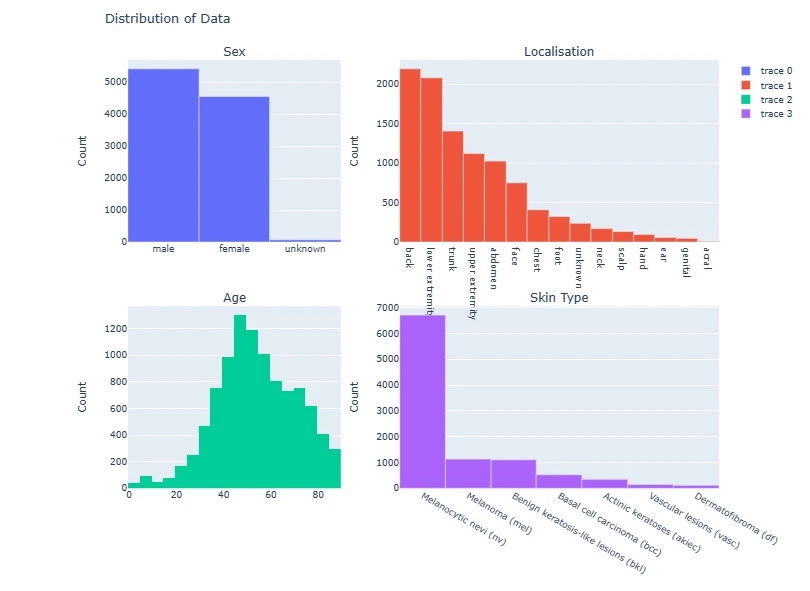

The code snippet below groups skin lesion images by their diagnosis labels ('dx'). For each label, it selects the first two images, displaying them in a grid of subplots. Using Matplotlib, it exhibits these images alongside their corresponding cell type labels, offering a visual representation of skin lesion samples categorized by diagnosis labels for quick inspection and comparison.

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

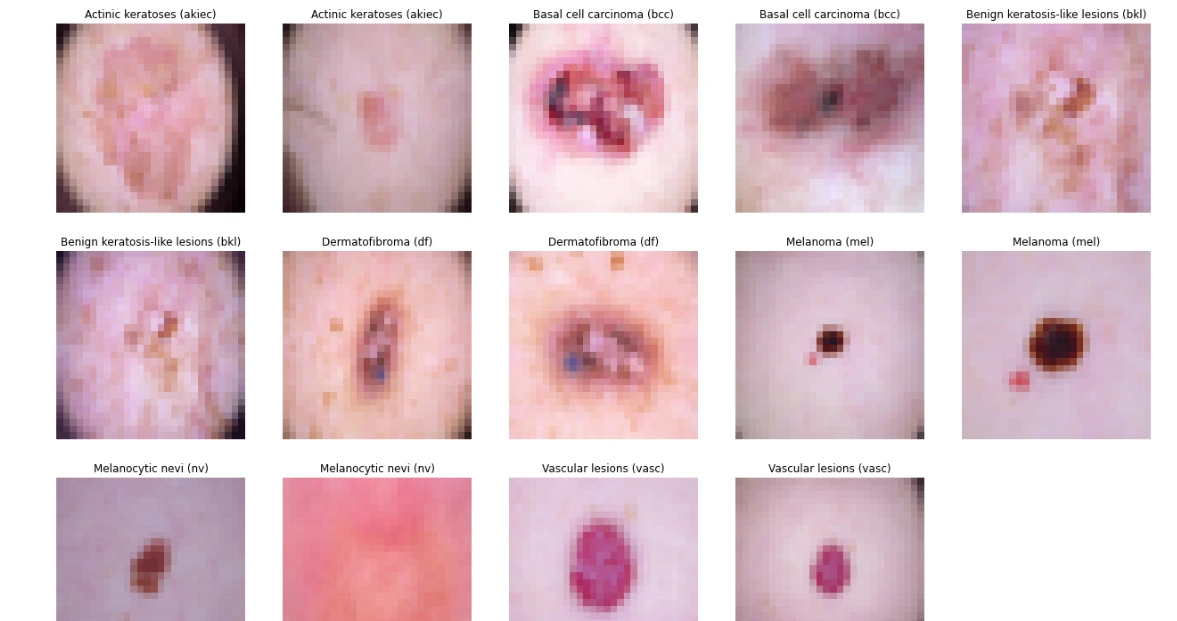

## ***Preprocessing***

Null values in the 'age' column are filled with the mean age and converted to integers. The 'label' column is created by mapping lesion types to numerical values for classification.

data.info()

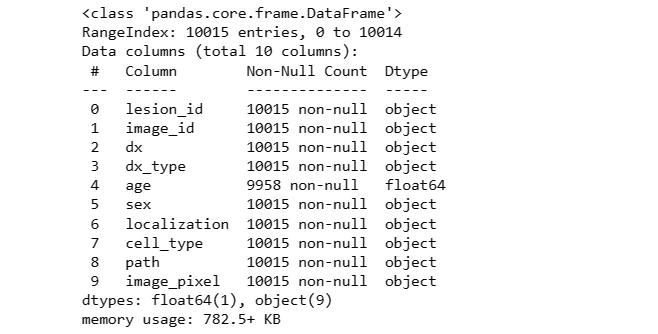

In [ ]:
# Checking null values
data.isnull().sum()

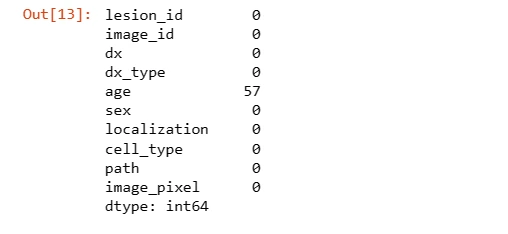

In [ ]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')
# Categorically encoding label of the images
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)


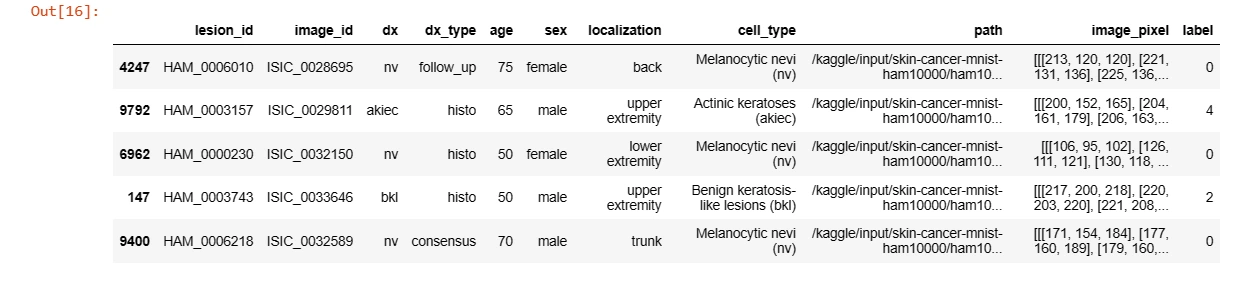

## ***Data Augmentation***

This section augments the data by oversampling different classes, aiming to balance the dataset. It then combines the original and augmented data to create a more robust dataset for training.

In [ ]:
data = data.sort_values('label')
data = data.reset_index()
%%time
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)
%%time
print(data.shape)
print(final_data.shape)
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

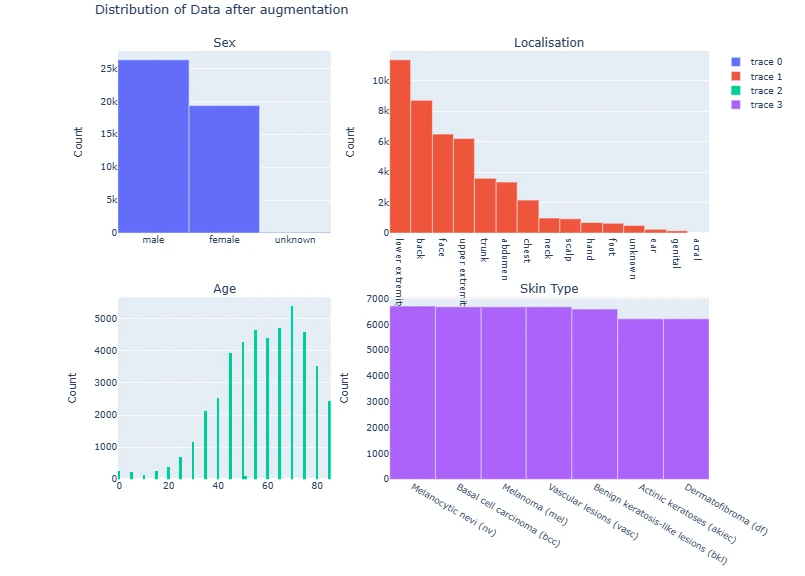

## ***Creating 2 sets of data for Model Training and Testing***

Original Data: Without solving the class imbalance problem

Augmented Data: After solving the class imbalance problem

In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)

(10015, 1)

In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)

(45756, 1)

## ***Model Creation, Training, and Testing***

This code snippet defines a sequential model architecture using Convolutional (Conv2D) and Pooling (MaxPool2D) layers along with fully connected (Dense) layers for classification. It compiles the model with an optimizer and loss function for training.

For Original Data:

In [ ]:
%%time
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)
model1 = create_model()


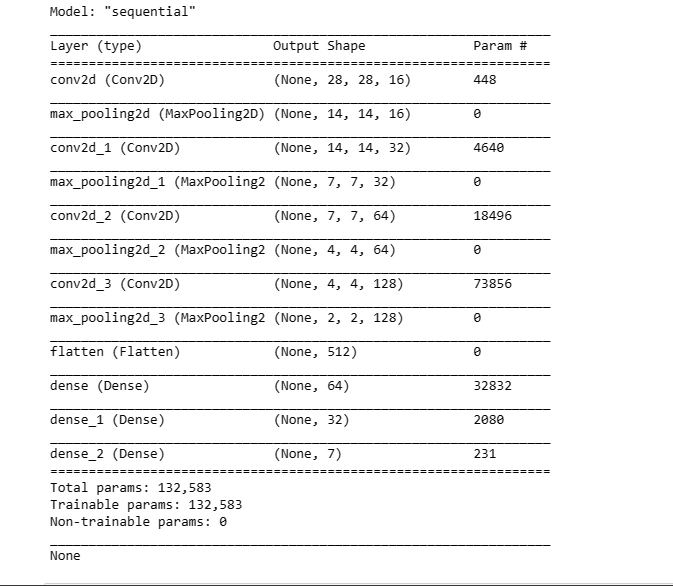

In [ ]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

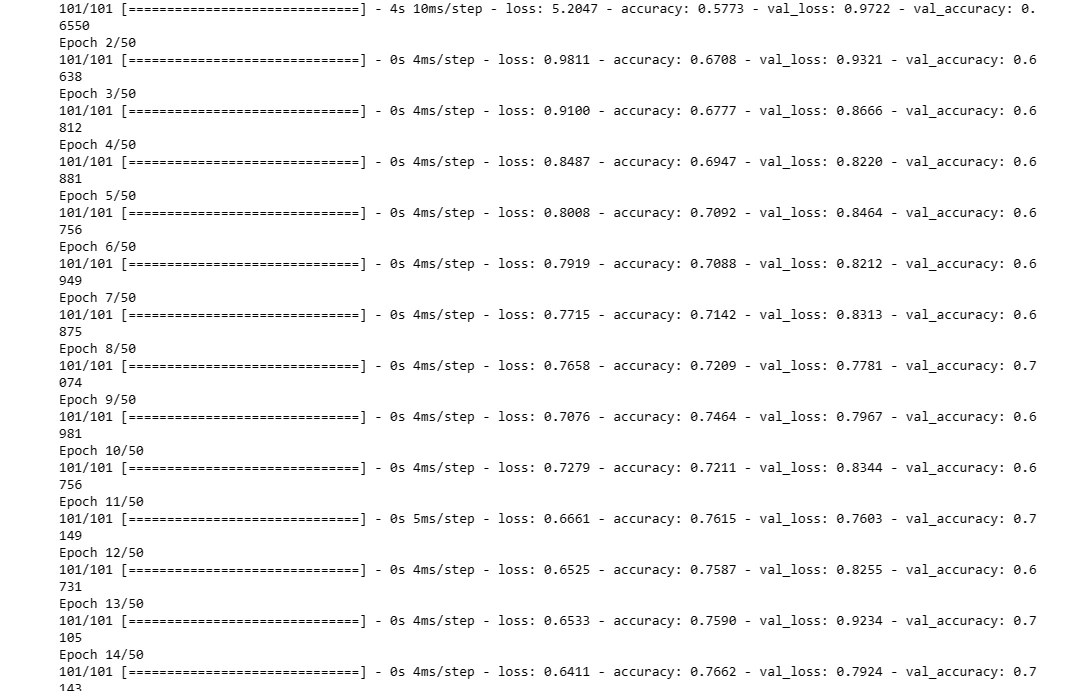

## ***For Augmented Dataset:***



In [ ]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)
model2 = create_model()

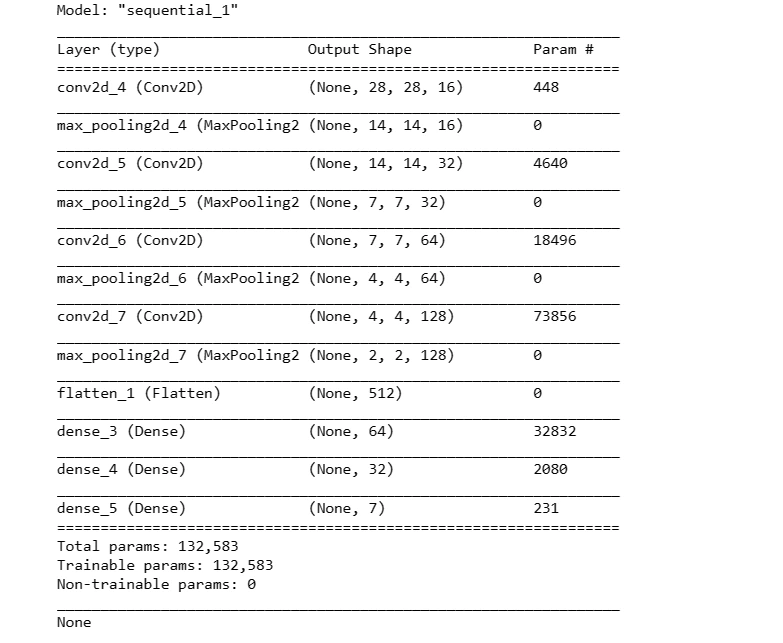

In [ ]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

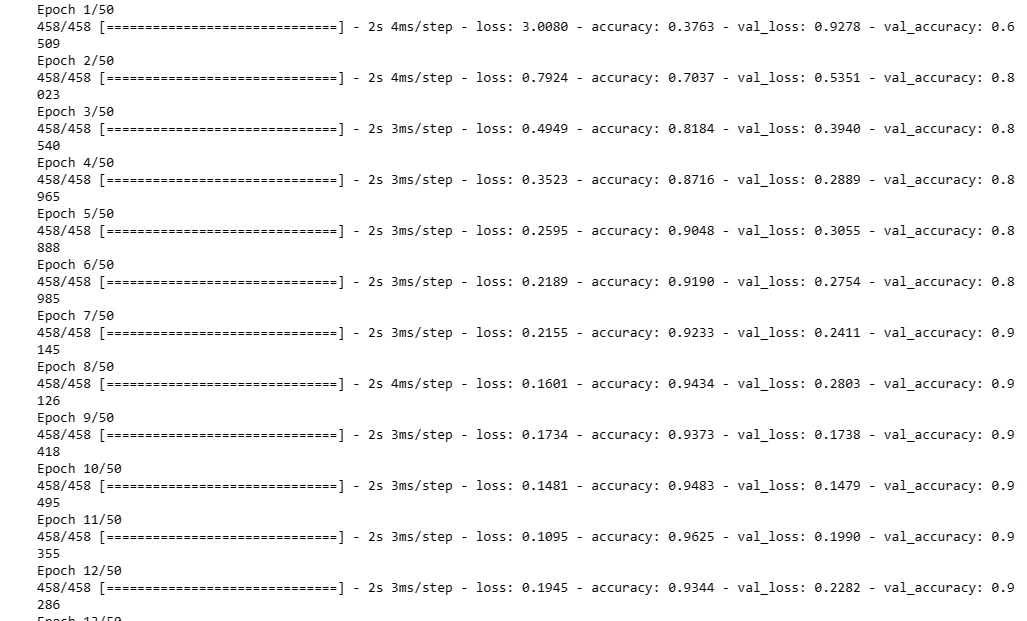

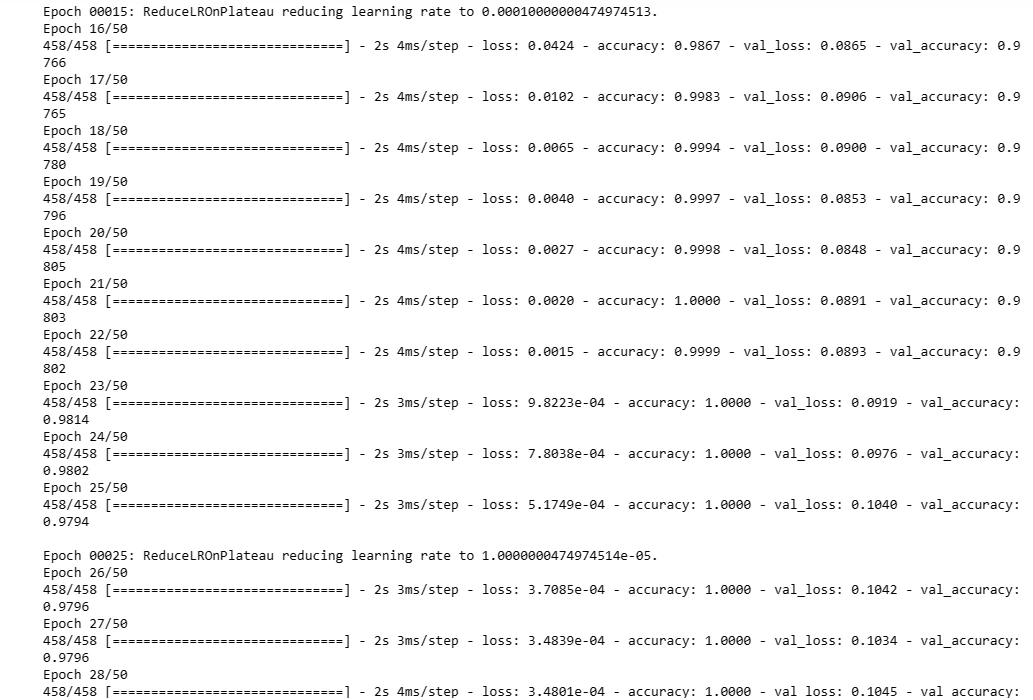

## ***Evaluation and Testing of Models***


The code snippet evaluates the performance of the neural network model 'model1' on a separate test dataset ('X_test_orig') and corresponding labels ('Y_test_orig').

It calculates the model's accuracy on the test data and generates a classification report, showcasing the model's predictive capability and its agreement with the ground truth labels for skin lesion classification.

For Original Dataset:

In [ ]:
test_model(model1, X_test_orig, Y_test_orig)

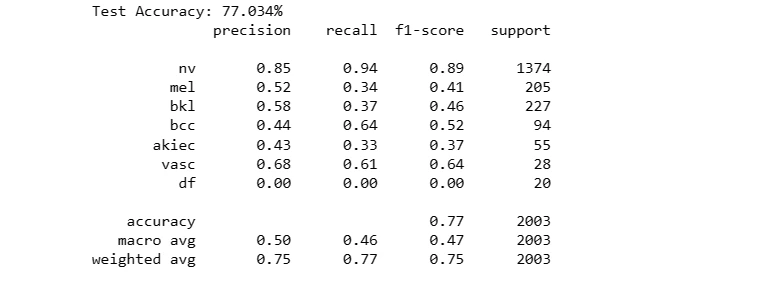

## *For Augmented Dataset:*

In [ ]:
test_model(model2, X_test_aug, Y_test_aug)

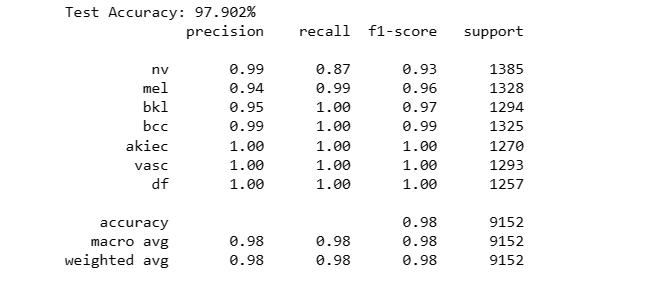

## ***Plotting Model Training Curve and Testing***


This section visualizes the model's performance by plotting training and validation accuracy/loss over epochs. Additionally, it evaluates the trained model on test data, displaying sample predictions versus true labels.

For Original Dataset

In [ ]:
plot_model_training_curve(model1_history)

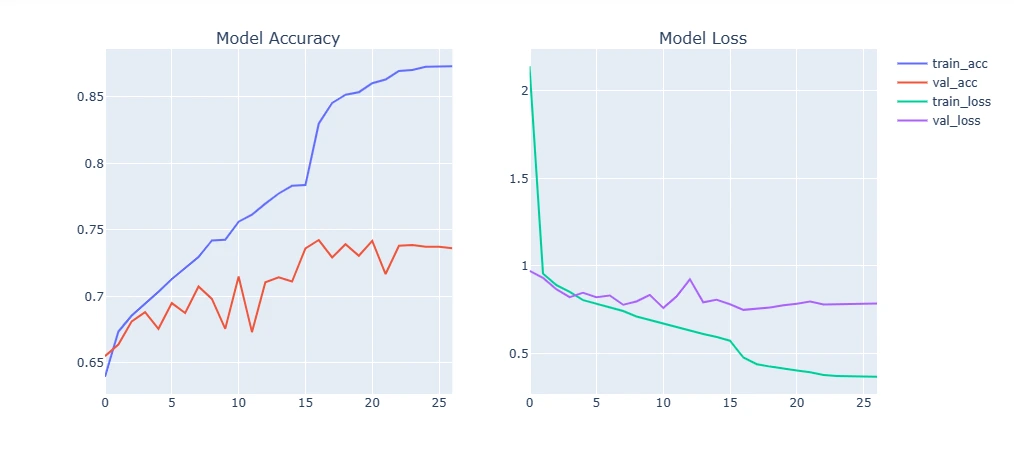

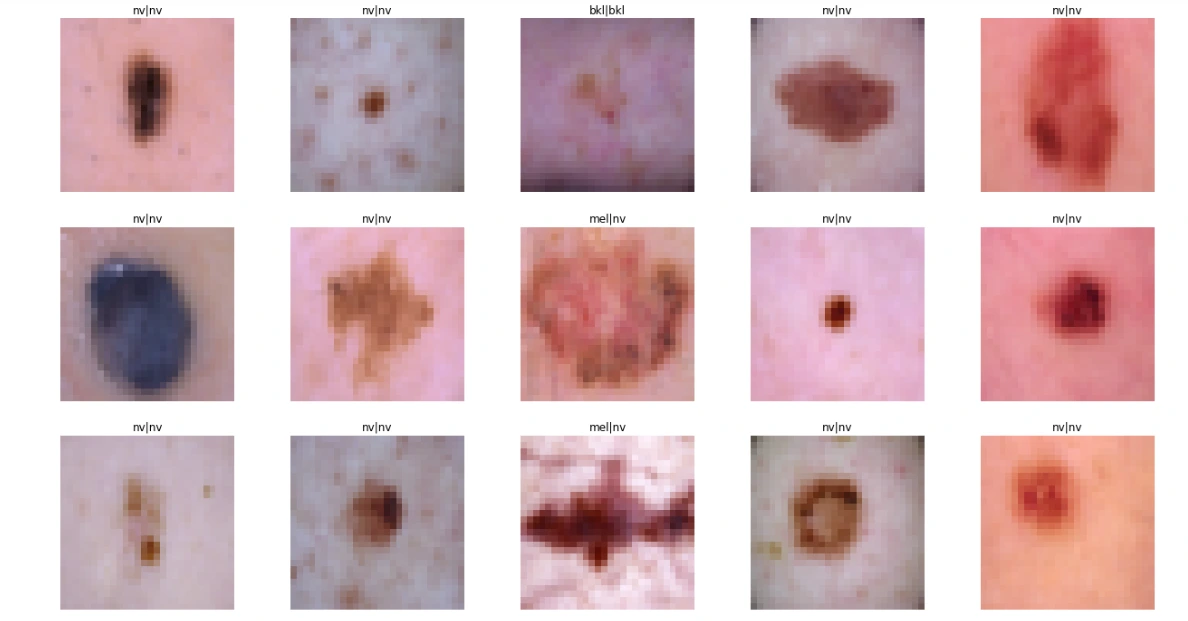

## ***For Augmented Dataset:***

In [ ]:
plot_model_training_curve(model2_history)


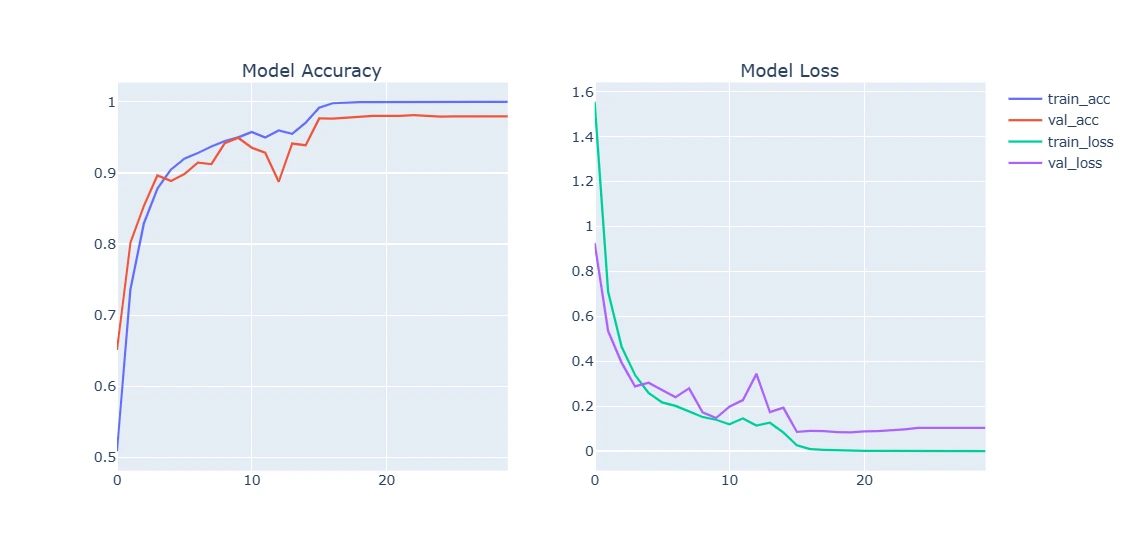

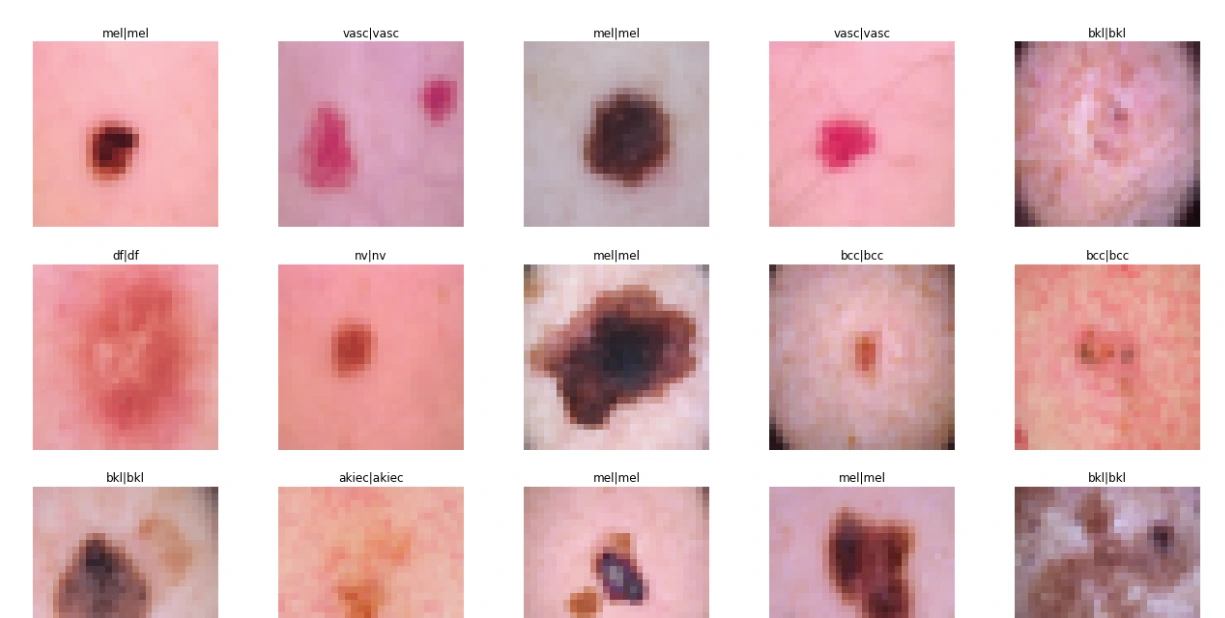

# ***Conclusion***


This Project  extensively covered the process of building a CNN model for skin cancer detection. It emphasized the importance of early detection and how AI-powered models can assist dermatologists in accurate diagnosis. Additionally, leveraging CNNs for skin cancer detection showcases the potential of technology in healthcare, especially in aiding medical professionals for timely interventions.